In [1]:
### Loading Credentials from local file; 
### this cell is meant to be deleted before publishing
import yaml

with open("../creds.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

uri = cfg["sonar_creds"]["uri"]
user = cfg["sonar_creds"]["user"]
password = cfg["sonar_creds"]["pass"]

<font size = "20"> SoNAR (IDH) - HNA Curriculum </font>

<font size = "5">Notebook 4:  Example Case - History of Physiology</font>

This notebook provides an example case of an exploratory approach to work with the SoNAR (IDH) data for historical network analysis. 

In this notebook we investigate an example case in the field of the history of physiology. We are going to analyze the full network of physiologists in the SoNAR (IDH) database and try to identify the most important people, corporations and works in this field. 
In this exploratory approach we start by asking very general questions about the network of physiologists and based on the insights we start asking more specific questions about the network. 


Before we start with the notebook, we load all the libraries needed in this notebook upfront.

In [2]:
from neo4j import GraphDatabase #the driver to connect to the SoNAR (IDH) database
import networkx as nx #the python network analysis library
from helper_functions.helper_fun import to_nx_graph #custom helper function
from helper_functions.helper_fun import draw_graph
import numpy as np #fast numerical computing library
import pandas as pd #library for working with tabular data
from operator import itemgetter #function for conviently working with dictionaries
import community as community_louvain #community detection algorithm for network analysis
import matplotlib.pyplot as plt #plotting library used for static visualizations
import community as community_louvain #louvain community detection algorithm

# Defining the Physiology Graph

At first we need to get an idea about the data related to physiology in the SoNAR (IDH) database. It's a good idea to start off with taking a look at `TopicTerms` related to physiology. Since the SoNAR data is in German, we need to use German terms to apply filters. Luckily, the German term for physiology is "Physiologie". Also, we do not search for the full term "Physiologie" but for "hysiolog" as a substring to retrieve every possible strings containing the term. 

Also note that we do not request a full graph but only the distinct `TopicTerms` containing the substring "hysiolog" in the code cell below:

In [3]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (t:TopicTerm)
WHERE t.Name CONTAINS "hysiolog"
RETURN DISTINCT(t.Name) as term
"""

with driver.session() as session:
    all_physiology_terms = session.run(query).data()
    
all_physiology_terms

[{'term': 'Arbeitsphysiologie'},
 {'term': 'Neurophysiologie'},
 {'term': 'Pathophysiologie'},
 {'term': 'Pflanzenphysiologie'},
 {'term': 'Physiologie'},
 {'term': 'Sinnesphysiologie'},
 {'term': 'Tierphysiologie'},
 {'term': 'Physiologische Chemie'},
 {'term': 'Physiologische Psychologie'},
 {'term': 'Sprachphysiologie'},
 {'term': 'Sportphysiologie'},
 {'term': 'Leistungsphysiologie'},
 {'term': 'Physiologische Psychiatrie'},
 {'term': 'Elektrophysiologie'},
 {'term': 'Altersphysiologie'},
 {'term': 'Bewegungsphysiologie'},
 {'term': 'Entwicklungsphysiologie'},
 {'term': 'Ernährungsphysiologie'},
 {'term': 'Ertragsphysiologie'},
 {'term': 'Histophysiologie'},
 {'term': 'Höhenphysiologie'},
 {'term': 'Nacherntephysiologie'},
 {'term': 'Physiologische Optik'},
 {'term': 'Physiologische Uhr'},
 {'term': 'Psychophysiologische Diagnostik'},
 {'term': 'Stoffwechselphysiologie'},
 {'term': 'Vegetative Physiologie'},
 {'term': 'Vergleichende Neurophysiologie'},
 {'term': 'Vergleichende Ph

As we can see, there are quite a lot of physiology related terms in the database. Some of these `TopicTerms` are specifications of subfields of physiology (e.g. "Arbeitsphysiologie" = *occupational physiology*) or gender specifications (e.g. "Physiologin" = *female physiologist*).

As we want to explore the network of physiologists, let's check whether all of these terms are actually connected to persons.

In [4]:
query = """
MATCH (t:TopicTerm)-[r]-(n:PerName)
WHERE t.Name CONTAINS "hysiolog"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

Now, we retrieved a full graph object. We can use this object to check which `TopicTerms` aren't present in query result. 

In the code cell below we use the method `setdiff1d()` from the *numpy* library. This method provides a convenient way to find the differences between two arrays. [Here](https://numpy.org/doc/stable/reference/generated/numpy.setdiff1d.html) you can find the documentation of the method.

In [5]:
relevant_topics = []
for node in list(G.nodes):
    if G.nodes[node]["type"] == "TopicTerm":
        relevant_topics.append((G.nodes[node]["label"]))

np.setdiff1d([d["term"] for d in all_physiology_terms], relevant_topics)

array(['Altersphysiologie', 'Bewegungsphysiologie',
       'Elektrophysiologische Untersuchung', 'Ertragsphysiologie',
       'Experimentelle Physiologie', 'Histophysiologie',
       'Ignaz-L.-Lieben-Preis für Physik, Chemie und Physiologie',
       'Muskelphysiologie', 'Physiologische Optik', 'Physiologische Uhr',
       'Psychophysiologische Diagnostik', 'Reizphysiologie',
       'Sprachphysiologie', 'Tauchphysiologie', 'Umweltphysiologie',
       'Vergleichende Neurophysiologie', 'Vergleichende Physiologie',
       'Zellphysiologie'], dtype='<U57')

As we can see in the output above, there are some physiology related terms in the database that are not connected to any persons. We won't analyze these terms in this notebook but we focus on the other ones instead. 

## Retrieving the Network

After we are confident that our search for physiology related terms yields correct results, we can query the full network of physiologists from the database. 

The query below will take some time to run through because we are retrieving quite some amount of nodes and edges.

Also, the query below uses a a procedure we did not use so far in this curriculum. Under the code chunk below you can find mire details on what is happening in the query:

In [6]:
query = """
MATCH (t:TopicTerm)--(n:PerName)
WHERE t.Name CONTAINS "hysiolog"
WITH DISTINCT [x in collect(t)+collect(n)|id(x)] as collectedIds 
MATCH (n)-[rel1:RelationToPerName|SocialRelation|RelationToResource|RelationToGeoName|RelationCorpName|RelationToUniTitle*0..1]-(n2)
WHERE id(n) in collectedIds 
RETURN n, n2, rel1
"""


driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

The query above uses two consecutive `MATCH` statements. The first `MATCH` statements retrieves all physiology related `TopicTerms` that are connected to nodes of persons and the person nodes the terms are connected to. Afterwards the IDs of all `TopicTerm` nodes and `PerName` nodes are collected and assigned to the object `collectedIds`. The collection is done via a [list comprehension](https://neo4j.com/docs/cypher-manual/current/syntax/lists/) and the aggregate function [collect()](https://neo4j.com/docs/cypher-manual/current/functions/aggregating/#functions-collect). Please refer to the linked documentation pages for more details. 

This way first `MATCH` statement results in an object containing all IDs of the relevant person nodes and term nodes for the physiology graph. The second `MATCH` statement does the final query as usual but we use the `collectedIds` object as a filter. So we only retrieve the relevant relationships and connected nodes off the physiology network. 


## Descriptive Metrics

Now we have the physiology graph. Next, let's check some descriptive metrics of the network to get an idea of it's basic characteristics:

In [7]:
print("Number of Nodes: ", G.number_of_nodes())
print("Number of Edges: ", G.number_of_edges())

Number of Nodes:  47732
Number of Edges:  56119


Our graph is apparently pretty large. Unfortunately, it doesn't make much sense to visualize such a large network in a Jupyter notebook. So we need to find meaningful ways to select the most relevant parts of the graph and thus shrink it down.
But before we jump into that, let's get some more descriptive metrics about the network:

In [8]:
types_list = list(set([y["type"] for x,y in G.nodes(data=True)]))

# The 5 lines below create objects containing only nodes of specific types. 
# Later on in this notebook we will use some of these objects again to use them as filters
person_nodes = [x for x,y in G.nodes(data=True) if y['type']=="PerName"]
resources_and_works_nodes = [x for x,y in G.nodes(data=True) if y['type'] in ["Resource", "UniTitle"]]
corps_nodes = [x for x,y in G.nodes(data=True) if y['type']=="CorpName"]
geo_nodes = [x for x,y in G.nodes(data=True) if y['type']=="GeoName"]
topicterm_nodes = [x for x,y in G.nodes(data=True) if y['type']=="TopicTerm"]

print("Node types in Graph:", types_list)
print("Number of Persons in Graph: ", len(person_nodes))
print("Number of Resources and Works in Graph: ", len(resources_and_works_nodes))
print("Number of Corporations in Graph: ", len(corps_nodes))
print("Number of GeoNames in Graph:", len(geo_nodes))
print("")
print("## Topic Terms in Graph: ## ")
for node in topicterm_nodes:
    print(G.nodes(data=True)[node]["label"])

Node types in Graph: ['Resource', 'PerName', 'GeoName', 'TopicTerm', 'CorpName', 'MeetName', 'UniTitle']
Number of Persons in Graph:  11727
Number of Resources and Works in Graph:  34304
Number of Corporations in Graph:  1094
Number of GeoNames in Graph: 560

## Topic Terms in Graph: ## 
Arbeitsphysiologie
Neurophysiologie
Pathophysiologie
Pflanzenphysiologie
Physiologie
Sinnesphysiologie
Tierphysiologie
Physiologische Chemie
Physiologische Psychologie
Sportphysiologie
Leistungsphysiologie
Physiologische Psychiatrie
Elektrophysiologie
Entwicklungsphysiologie
Ernährungsphysiologie
Höhenphysiologie
Nacherntephysiologie
Stoffwechselphysiologie
Vegetative Physiologie
Verhaltensphysiologie
Physiologe
Physiologin
Physiologische Akustik
Pflanzenphysiologe
Pflanzenphysiologin
Bernoulli-Balken
Bernoulli-Balken
Bathybius haeckelii
Bathybius haeckelii


### Check Density and Connectedness of Network

Since our network is pretty large, it is a bit complicated to investigate the network visually from within this notebook. This is why we start investigating the network with some further descriptive assessments. 


Let's start with the *density* of the network. The *Network density* measures how many relationships between nodes exist in relation to how many relations are possible. Graph density for an undirected Graph is calculated as follows:

\begin{align}
x & = \frac{m}{n(n-1)/2}
\end{align}

$n$ is the number of nodes and $m$ is the number of relationships in the graph. By calculating $n(n-1)/2$ we get the number of possible relationships in the graph. Basically we divide the number of actual edges in the graph by the number of possible edges and so we get the *density*. 
When every node is connected to every other node in the network, the density is 1. On the other hand, when there are no relationships between any nodes, the density is 0. 

We calculate the density to see how connected our graph is. 

The formula for a directed graph is slightly different from the formula presented above. Click [here](https://networkx.org/documentation/stable/reference/generated/networkx.classes.function.density.html?highlight=density) for more details.

In [9]:
nx.density(G)

4.926400935949988e-05

As we can see, the density of our network is very low. This means that the nodes in our network are not very connected to each other. This could mean, that the graph consists of many isolated nodes or many little *components*. 

Let's at first check whether this assumption is true. To do so, we can assess the *connectivity* of the graph. A graph is considered to be connected, as long as there is a possibility to traverse from every node in the graph to any other node. Or in other words: A graph is disconnected, when it consists of isolated subgraphs, also called *components*.

We can use the `is_connected()` method of the networkx library to do the connectivity check. [Here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.is_connected.html#networkx.algorithms.components.is_connected) you can find the documentation of the function. 



In [10]:
nx.is_connected(G)

False

Apparently the physiology graph is not fully connected and therefore there are isolated components in the graph. So let's try to understand, what these components are.

**Components** 

Whenever you work with a network taken from the real world, it's quite common that the network is not fully connected. 
As we just found out, the physiology network also seems to consist of isolated "islands of nodes". Let's find out how many components our network has and how big they are. 

We will use some of the components algorithm the `networkx` library provides. [Here](https://networkx.org/documentation/stable/reference/algorithms/component.html) you can find an overview of all components related algorithms available. 

We can use the method `number_connected_components()` to retrieve the number of components in our graph.

In [11]:
nx.number_connected_components(G)

687

There are nearly 700 separate components present in the graph. Let's investigate them further.

By using the method `connected_components()` we can get a list containing the nodes present in each of the available components.  

In [12]:
# retrieve a list of all components and the associated nodes
components = nx.connected_components(G)

# now we create a list containg the information about each component size (number of nodes)
component_size_list = [len(component) for component in components]

# let's print some summary details
print("number of unique component sizes (number of nodes):", len(set(component_size_list)))
print("maximum component length:", max(set(component_size_list)))
print("minimum component length:", min(set(component_size_list)))

number of unique component sizes (number of nodes): 24
maximum component length: 45921
minimum component length: 1


Alright, as we can see from the output above, there are 24 distinct component sizes. This means that each of the present components takes one of 24 different sizes. The sizes of the components have a range from 1 node (a single node without any relationships) to 45921 nodes. 

Let's check the distribution of the components sizes next.

<AxesSubplot:>

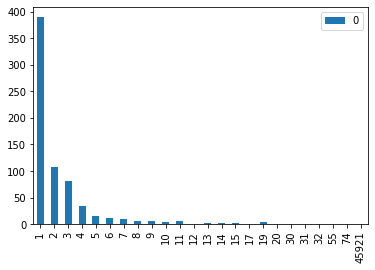

In [13]:
values, counts = np.unique(component_size_list, return_counts=True)
pd.DataFrame(counts, values).plot.bar()

More than 50% of the components in our graph are isolated nodes. There are quite some components with just a few nodes in them. But there is this one huge cluster with 45921 nodes. 

Let's create a subgraph of the largest component. As we want to explore the network of physiologists it might be most interesting to investigate the largest component and not the smaller ones.

We can use the method `subgraph()` to extract the graph of the largest component. We just need to pass in a list of nodes we want to include in the new subgraph. Click [here](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html) for the documentation of the method.

In [14]:
# at first we extract the the largest component

components = nx.connected_components(G)
largest_component = max([component for component in components], key = len)
print(len(largest_component))

largest_component_graph = G.subgraph(largest_component)

45921


Now we have our subgraph and we know that it is a connected graph now. Let's check if this assumption is true:

In [15]:
nx.is_connected(largest_component_graph)

True

Perfect, so let's go on investigating this subgraph now.

# Investigating the Persons

The biggest part of our investigations will focus on the persons in the graph. However, the methods applied in the following section can be applied to any kind of node type in the graph. 

## Centrality Investigation

At first we are going to investigate the centrality of the physiology network. By assessing the centrality we actually calculate the importance or the role of the nodes in a graph. Centrality metrics are used to identify the most important nodes in a network. Also, these metrics can be helpful to understand group dynamics like credibility, accessibility or flow of information. 

In this section, we won't apply *path-based algorithms* like *betweenness centrality* or *information centrality*, because path based calculations are very costly computational wise. A small overview of centrality metrics you can choose from provides the table below.

| Centrality name | Characteristics of a central node|
|:----------------|:---------------|
|Degree Centrality|Connected to many other nodes|
|Eigenvector Centrality|Connected to many other nodes and/or to other high-degree nodes|
|PageRank|Connected to many other nodes and connected to other high-degree nodes|
|Shortest-path Betweenness Centrality|Lies on many shortest topological paths linking other node pairs|
|Shortest-path Closeness| Low average shortest path length to other nodes in the network|

<center>
(Oldham at al., 2019)
</center>

The choice of the best centrality metric for your network or your research question can be rather difficult, since there are quite a lot centrality metrics available. Also, it is still a matter of ongoing research to evaluate the degree of unique information each metric provides compared to the other centrality metrics (Oldham et al., 2019). 
We are going to check out two of the most common centrality metrics to see how the results can differ between them.



### Degree Centrality

Let's start off with the simplest centrality metric - **Degree Centrality**. Degree is defined as the number of incoming and outgoing relationships of a node. The degree can either be calculated as the sum of relationships or as the fraction of nodes a node is connected to. The latter one normalizes the metric. 

Mathematically,  degree centrality is defined as $ d_i = \sum_{j\ne i}A_{ij} $. 

where $A_{ij}$ is the adjacency matrix.

We can calculate the degree centrality with the `networkx` package by using `degree_centrality()`. Check out the [documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html) for more details.


In [16]:
degrees = nx.degree_centrality(largest_component_graph)

The `degrees` object we just created, holds a dictionary with all node ids and their respective centrality as fraction.
Let's order the result from highest to lowest degree.

In [17]:
# at first we sort the degree values in descending order
degrees_sorted = sorted(degrees.items(), key = itemgetter(1), reverse = True)

# now we apply a filter because we only want to investigate persons 
degrees_filtered = [item for item in degrees_sorted if item[0] in person_nodes] 

# next, we exgract the top ten people by degree
top_degrees = degrees_filtered[:10]

In the code block above we used the `person_nodes` object as a filter. This object was created in Chapter [Descriptive Metrics](#Descriptive-Metrics). Revisit this chapter if want to check again how this object was created. 

Alright, let's have a look at the top ten physiologists by degree centrality:

In [18]:
for i in top_degrees: 
    degree = degrees[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Degree Centrality:", i[1])

Name: Wundt, Wilhelm | Degree Centrality: 0.16583188153310105
Name: Oken, Lorenz | Degree Centrality: 0.05505226480836237
Name: Baer, Karl Ernst von | Degree Centrality: 0.05215592334494774
Name: Pirson, André | Degree Centrality: 0.04695121951219512
Name: Eccles, John C. | Degree Centrality: 0.04213850174216028
Name: Haller, Albrecht von | Degree Centrality: 0.03523519163763066
Name: Cohn, Jonas | Degree Centrality: 0.02968205574912892
Name: Du Bois- Reymond, Emil Heinrich | Degree Centrality: 0.024259581881533102
Name: Sömmerring, Samuel Thomas von | Degree Centrality: 0.023083623693379792
Name: Helmholtz, Hermann von | Degree Centrality: 0.02219076655052265


The most important physiologist in our network by degree centrality is Wilhelm Wundt.

So far we only worked with the normalized degree centrality values. We also can check the degree centrality as a total off course. Let's see how many ingoing and outgoing relationships Wilhem Wundt has:

In [19]:
largest_component_graph.degree(top_degrees[0][0])

7615

### Eigenvector Centrality

The degree centrality we just calculated, only tells us about the quantity of relationships a node owns. A more complex calculation is the **Eigenvector Centrality** which also takes the "quality" of a relationship into consideration. The basic idea of the eigenvector centrality is: *It does not only matter how many relationships a node has, but it also matters whether a node has relationships to other high-degree nodes.* 

The eigenvector centrality is defined as:

$ EC_i = \frac{1}{\lambda_1}\sum_j A_{ji}v $

where $\lambda_1$ is the leading eigen*value* of the adjacency matrix $A_{ji}$, and $v$ is the leading eigen*vector* of $A$.

The eigenvector centrality is used when we want to investigate a node's importance in respect to the importance of it's neighbors. 

Let's try that out. At first we calculate the eigenvectors with the `eigenvector_centrality_numpy()` function. Click [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.eigenvector_centrality_numpy.html) for more details. 

In [20]:
eigenvectors = nx.eigenvector_centrality_numpy(largest_component_graph)

Again, we sort the values in descending order and print the top ten physiologists by eigenvector centrality: 

In [21]:
eigenvectors_sorted = sorted(eigenvectors.items(), key = itemgetter(1), reverse = True)

eigenvectors_filtered = [item for item in eigenvectors_sorted if item[0] in person_nodes]
top_eigenvectors = eigenvectors_filtered[:10]

for i in top_eigenvectors: 
    degree = eigenvectors[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Eigenvector Centrality:", i[1])

Name: Wundt, Wilhelm | Eigenvector Centrality: 0.7057079896756637
Name: Helmholtz, Hermann von | Eigenvector Centrality: 0.024370598658592625
Name: Oken, Lorenz | Eigenvector Centrality: 0.02030453921038477
Name: Du Bois- Reymond, Emil Heinrich | Eigenvector Centrality: 0.018596639803144976
Name: Cohn, Jonas | Eigenvector Centrality: 0.01705806400518026
Name: Müller, Johannes | Eigenvector Centrality: 0.014932812346634558
Name: Tschermak-Seysenegg, Armin von | Eigenvector Centrality: 0.014342534150727889
Name: Weber, Ernst Heinrich | Eigenvector Centrality: 0.0141333449988061
Name: Henle, Jakob | Eigenvector Centrality: 0.01249579835633749
Name: Bernstein, Julius | Eigenvector Centrality: 0.0111625642024987


Apparently, Wilhelm Wundt does not only have the highest degree centrality but also the highest eigenvector centrality. Also, we can see that top ten physiologists by eigenvector differ slightly from the top ten physiologists by degree centrality. This means it matters quite a bit whether you are only interested in the total count of relationships a node has, or if you want to identify those nodes best connected to other meaningful nodes. 


Since we now identified Wilhelm Wundt as the most important node in our graph, let's extract his ego-network to visually check what importance he plays in the network.

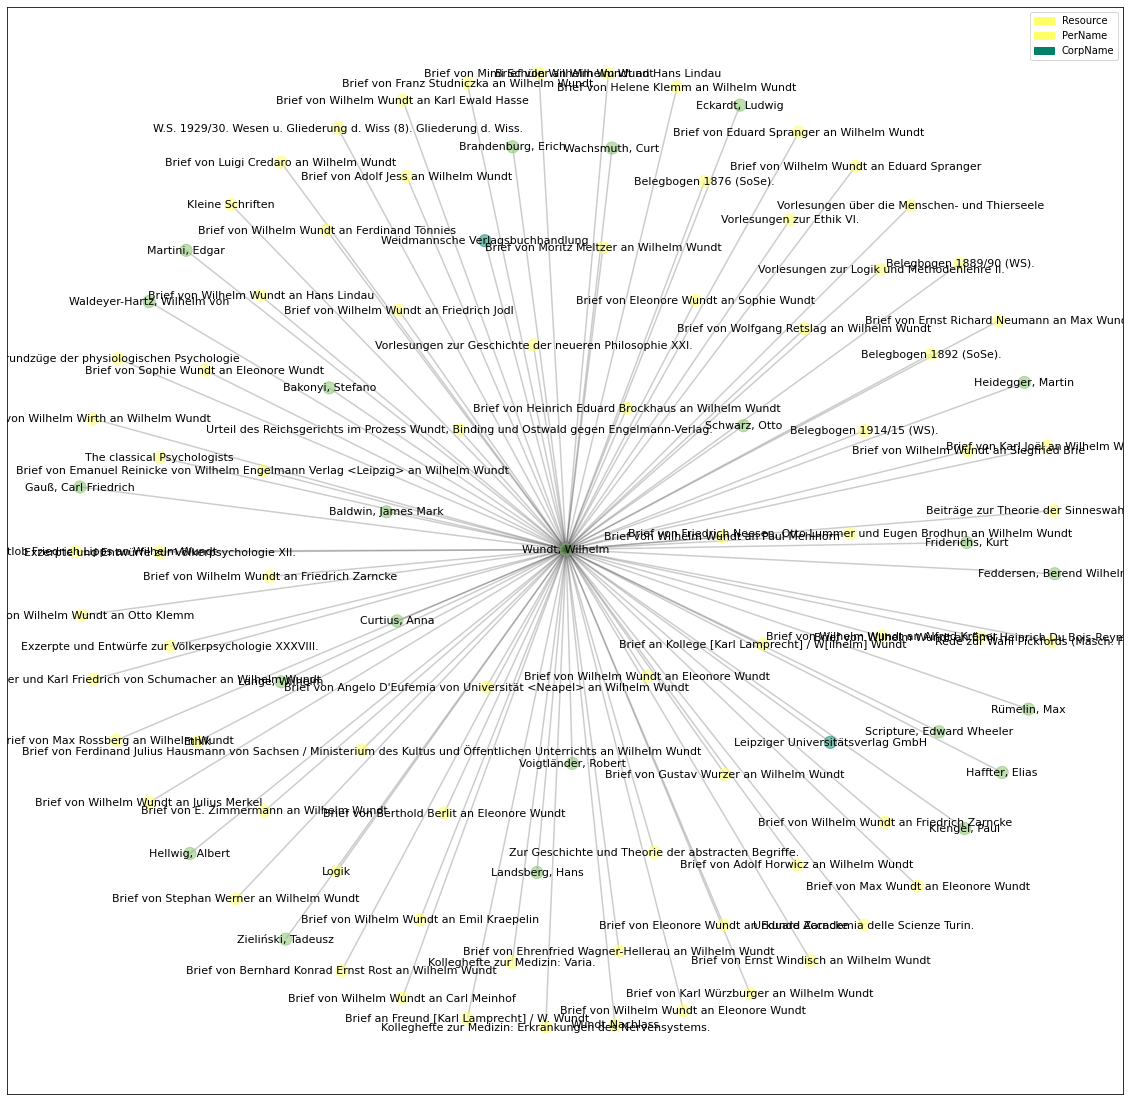

In [22]:
from random import sample

# extract the id of Wilhelm Wundt 
wilhelm_wundt_id = top_eigenvectors[0][0]

# get the subgraph of Wilhelm Wundt
wilhelm_wundt_ego_net = nx.ego_graph(largest_component_graph, wilhelm_wundt_id)

# the graph of wilhelm wundt is still quite large. So we create a random sampled subgraph of his ego graph
k = 100 #number of nodes to sample
sampled_nodes = sample(wilhelm_wundt_ego_net.nodes(), k)

# we need to make sure, that wilhelm wundt's id is also in the graph
if wilhelm_wundt_id not in sampled_nodes:
    sampled_nodes.extend([wilhelm_wundt_id])

sampled_ego_graph = nx.subgraph(wilhelm_wundt_ego_net, sampled_nodes)

# extract node labels
node_labels = nx.get_node_attributes(sampled_ego_graph, "label")

draw_graph(sampled_ego_graph, node_labels=node_labels, plot_size=[20,20])

### Centrality of Women

The centrality investigation only brought up men in the list of the top ten physiologists. Let's also find out the top ten women amongst the physiologists. 

We do not need to adjust the code a lot to get the eigenvector centrality for women only, we just need to change the filter a little: 

In [23]:
# let's filter for women only. Women are coded as "2" in the "Gender" attribute
women_nodes = [x for x,y in largest_component_graph.nodes(data=True) if "Gender" in y and y['Gender']=="2"]

eigenvectors_women = [item for item in eigenvectors_sorted if item[0] in women_nodes]
top_eigenvectors_women = eigenvectors_women[:10]

for i in top_eigenvectors_women: 
    degree = eigenvectors[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Eigenvector Centrality:", i[1])

Name: Wundt, Eleonore | Eigenvector Centrality: 0.008510587343799373
Name: Tschermak-Woess, Elisabeth | Eigenvector Centrality: 0.00847085050796523
Name: Wundt, Sophie | Eigenvector Centrality: 0.00842860860252471
Name: Feddersen, Helga | Eigenvector Centrality: 0.008231970708349433
Name: Schmiedel, Clara | Eigenvector Centrality: 0.008231970708349433
Name: Wiener, Lina | Eigenvector Centrality: 0.008231970708349431
Name: Krüger, Margarete | Eigenvector Centrality: 0.008231970708349431
Name: Oettingen, Elsa von | Eigenvector Centrality: 0.008231970708349426
Name: Wundt, Marie Friederike | Eigenvector Centrality: 0.008191844692311927
Name: Cohnheim, Martha | Eigenvector Centrality: 0.00808263414609114


The most influential woman by eigenvector centrality in the physiologists network is Eleonore Wundt - the daughter of Wilhelm Wundt. This makes sense, since her father is the most influential person in the full graph and since eigenvector centrality ranks you high when you are connected to high ranking nodes, it's not too surprising that people that were close to Wilhelm Wundt also rank high in regards of eigenvector centrality values. 

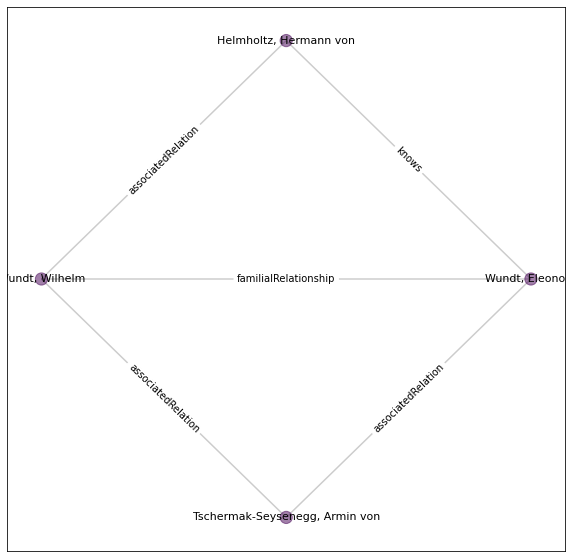

In [24]:
# extract the id of Wilhelm Wundt 
eleonore_wundt_id = top_eigenvectors_women[0][0]

# get the subgraph of Wilhelm Wundt
eleonore_wundt_ego_net = nx.ego_graph(largest_component_graph, eleonore_wundt_id)

node_labels_names = nx.get_node_attributes(eleonore_wundt_ego_net, "labels")
edge_labels = nx.get_edge_attributes(eleonore_wundt_ego_net, "SourceType")


draw_graph(eleonore_wundt_ego_net, node_labels=node_labels, edge_labels=edge_labels)

## Investigating Cliques

We can not only investigate components but also cliques. In the last section we saw that components are sub-elements of graphs that are connected. Components can be seen as "islands" in your network. Cliques on the other hand are defined by how strong or dense nodes are tied together in comparison to their tie to other nodes in the network. When there are nodes that are very close to each other (e.g. by sharing a lot of relationships with each other) but do not have many relationships to other nodes, they are considered a clique. 

So when talking about cliques it's not about the mere presence of relationships but about whether there are groups inside the graph that are very tightly linked together e.g. by the number of relationships or the weight of relationships. 
Another difference between components and cliques is that any two nodes of a clique are connected to each other. A more graph theoretical way to express this would be: The path length between any two nodes in a clique is exactly 1. In a component this is not necessarily the case, the path length between two nodes in a component can be larger than 1. 

The process of finding cliques in a graph is a quite complex problem and it's optimization still subject to ongoing research in computer science. If you want to dive deeper into this field you could start by reading about the [Clique Problem](https://en.wikipedia.org/wiki/Clique_problem). 

We will use the function `find_cliques()` from the `networkx` package to retrieve the cliques in the `largest_component_graph` object we created earlier. You can find the documentation of this function [here](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.clique.find_cliques.html?highlight=find_cliques#networkx.algorithms.clique.find_cliques).

In [25]:
# retrieve a list of all cliques and the associated nodes
cliques = nx.find_cliques(largest_component_graph)

# now we create a list containg the information about each clique size (number of nodes)
clique_size_list = [len(clique) for clique in cliques]

# let's print some summary details
print("number of unique clique sizes (number of nodes):", len(set(clique_size_list)))
print("maximum clique size:", max(set(clique_size_list)))
print("minimum clique size:", min(set(clique_size_list)))

number of unique clique sizes (number of nodes): 10
maximum clique size: 20
minimum clique size: 2


The glimps at the distribution of the cliques in the largest component we identified earlier shows that there are cliques in the graph with sizes ranging between 2 and 20. There are 10 different clique sizes in total. Let's check out the histogram of the distribution: 

<AxesSubplot:>

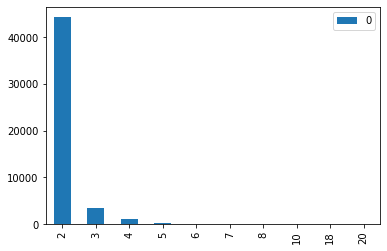

In [26]:
values, counts = np.unique(clique_size_list, return_counts=True)
pd.DataFrame(counts, values).plot.bar()

The distribution looks pretty similar to the one we saw when analyzing the components. There are more than 40000 cliques of the size 2. This is not very relevant for us, since this is the smallest possible clique size. 
The larger cliques are more interesting to investigate since they are a hint that there are larger subgroups in the graph that are extraordinarily well connected. This could be a hint for very different phenomena depending on the context of the network. 

In our graph, there are nodes of physiologists as well as nodes of related works, locations, corporations and more. So a large connected clique could be a hint for a research group, important university communities or influential publications. 

Let's check out the largest clique in the network next:

In [27]:
cliques = nx.find_cliques(largest_component_graph)
relevant_cliques = [clique for clique in cliques if len(clique) == 20]
clique_nodes = set(n for clique in relevant_cliques for n in clique)
cliques_subgraph = G.subgraph(clique_nodes)

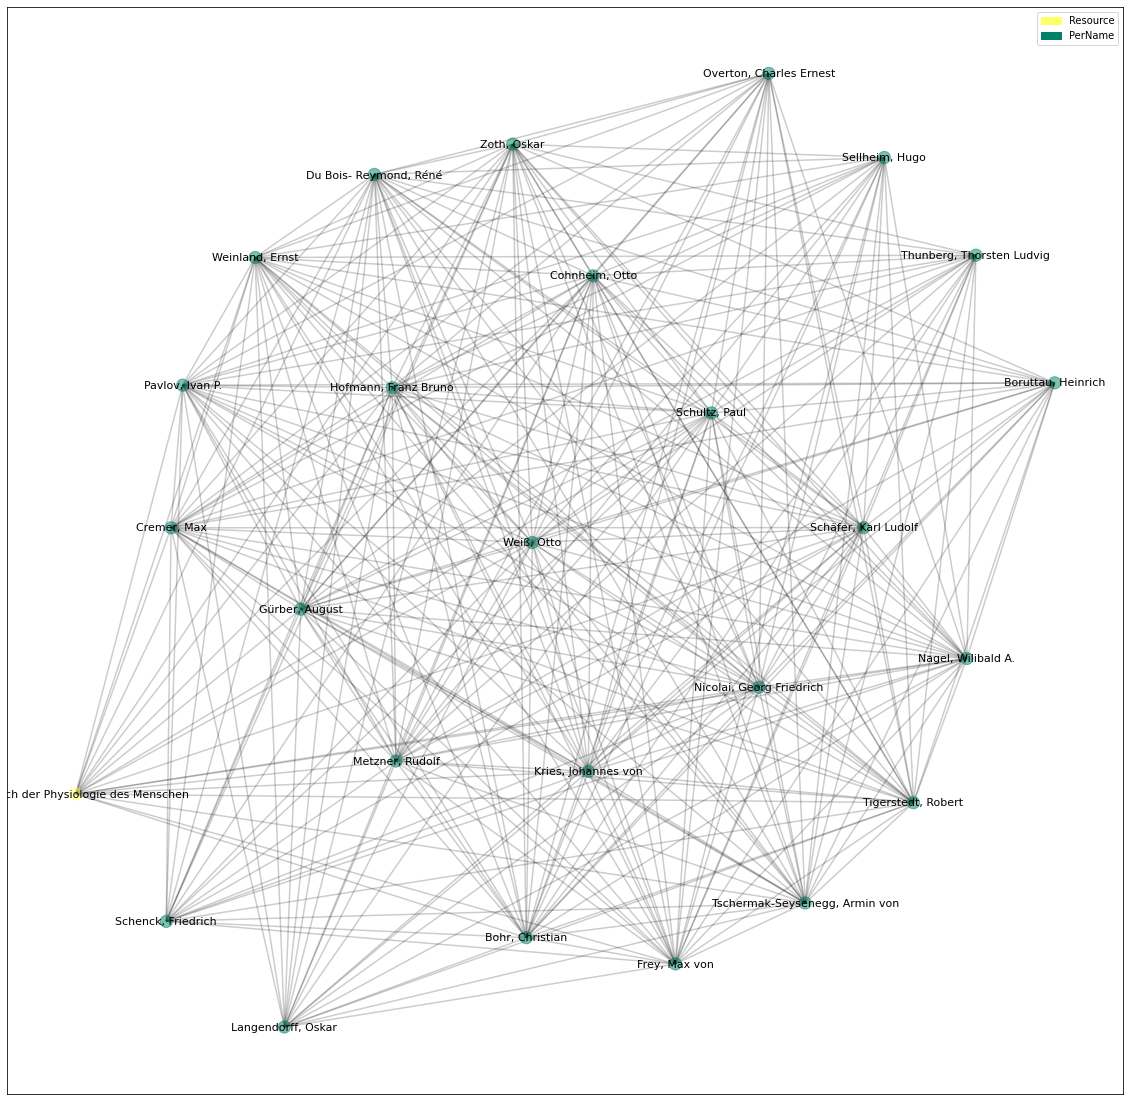

In [43]:
node_labels = nx.get_node_attributes(cliques_subgraph, "label")

draw_graph(cliques_subgraph, node_labels=node_labels, color_map=color_map, plot_size=[20,20])

## Community Detection

The third big concept of analyzing subgroups of networks is the *community*. Communities are similar to cliques but the concept is less strict. 

As discussed earlier, cliques are characterized by the fact that all nodes in the clique are connected to each other and that the ties amongst the nodes in a clique are stronger than to nodes outside of the clique. 

Communities also have the characteristic that nodes in a community have stronger bonds among each other than to nodes outside of the community. But in contrast to cliques, it's not mandatory for any two nodes in a community to have a direct relationship to each other. 

One of the most common community detection algorithms is the *Louvain algorithm* developed by Blondel at al. (2008). The Louvain algorithm is so popular due to it's quick computation time and the overall good performance in regards of detecting plausible communities. 

The Louvain algorithm optimizes for a modularity function iteratively and eventually detects communities of nodes that are highly connected to each other. A more in depth explanation of the algorithm would be beyond the scope of this curriculum. But the following list of resources provides a good starting point in case you want to dog deeper into the topic:

* [[Paper] Fast unfolding of communities in large networks](https://arxiv.org/abs/0803.0476)
* [[Blog Article] Communities and cliques by B. Rosenthal from the UC San Diego](http://compbio.ucsd.edu/communities-and-cliques/)
* [Modularity of Networks](https://en.wikipedia.org/wiki/Modularity_(networks))

Let's get apply the algorithm and get the communities in the `largest_component_graph`. We use a new library now called `community`. This library extends the base functionality of the `networkx` package by the Louvain algorithm. For more details on the function `community_louvain.best_partition()` consult the official documentation of the library [here](https://python-louvain.readthedocs.io/en/latest/).

In [29]:
communities = community_louvain.best_partition(largest_component_graph)

The result of the function above is a dictionary that maps each node id in the graph to a numeric representation of the community membership. In the next step we create a *Pandas data frame* from the dictionary. This way it is easier to create summary statistics and descriptive metrics.

In [30]:
communities_df = pd.DataFrame(list(communities.items()), columns = ["node", "community_id"])
communities_df

,node,community_id
0,5047581,0
1,1498433,1
2,1498931,0
3,10025185,0
4,17536046,0
...,...,...
45916,232074,39
45917,29778126,39
45918,4701781,22
45919,1505002,22


Now let's group the table by the `community_id` variable to see how many nodes each of the communities consists of:

In [31]:
agg_communities = communities_df.groupby("community_id").count().sort_values("node", ascending = False)
agg_communities

,node
community_id,
58,6914
18,2811
2,2290
65,2264
55,2224
...,...
60,20
7,20
40,18


The output above shows us an ordered glimpse of the aggregated data frame. We can see that the largest community is community number 60 with nearly 7000 nodes. The smallest community is community number 32 with only 9 nodes. 

TASK: use the `describe()` method to get a more detailed overview of dispersion metrics.

We also can generate a histogram from the data frame to get an idea of the distribution of the community sizes:

array([[<AxesSubplot:title={'center':'node'}>]], dtype=object)

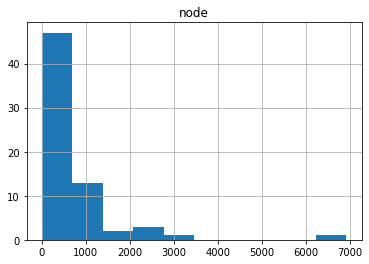

In [32]:
agg_communities.hist()

Alright, now let's actually visualize a community we found. Earlier we found out that Wilhelm Wundt is the most influential person in the physiologist graph by eigenvector centrality. So, let's check out what community he belongs to.

In [33]:
# let's retrieve the row of the data frame of wilhelm wundt
communities_df[communities_df["node"] == wilhelm_wundt_id]["community_id"].values

array([58])

Wilhelm Wundt belongs to the largest community. So let's visualize this community.

In [34]:
community_selection = communities_df[communities_df["node"] == wilhelm_wundt_id]["community_id"].values

nodes = {k:v for (k,v) in communities.items() if v == community_selection}.keys()

selected_community_graph = largest_component_graph.subgraph(nodes)

In [35]:
node_labels_names = nx.get_node_attributes(selected_community_graph, "label")

edge_labels = nx.get_edge_attributes(selected_community_graph, "SourceType")

draw_graph(selected_community_graph, node_labels=None, edge_labels=None, 
           color_map = color_map, plot_size=[20,20])

KeyboardInterrupt: 

# Investigating Corporations

So far we predominantly focused on exploring people in the graph. Let's change our subject now, and investigate the corporations in the network. The steps we need to do are very similar to the ones we applied for the people focused analyses. 

Let's find out the most central corporations by calculating the eigenvector centrality for them. Afterwards we check for cliques and communities. 

In chapter [Eigenvector Centrality](#Eigenvector-Centrality) we created the `eigenvectors` object, containing all eigenvector values for the `largest_component_graph` object. We can use this `eigenvectors` again and apply a filter so we only retrieve the top ten corporations by eigenvector values:

In [36]:
eigenvectors_sorted = sorted(eigenvectors.items(), key = itemgetter(1), reverse = True)

# apply filter to only include persons
eigenvectors_filtered = [item for item in eigenvectors_sorted if item[0] in corps_nodes]
top_eigenvectors = eigenvectors_filtered[:10]

for i in top_eigenvectors: 
    degree = eigenvectors[i[0]] 
    print("Name:", largest_component_graph.nodes(data = True)[i[0]]["label"], "| Eigenvector Centrality:", i[1])

Name: J.C.B. Mohr (Paul Siebeck) | Eigenvector Centrality: 0.009439143090247886
Name: J. G. Cotta'sche Buchhandlung | Eigenvector Centrality: 0.009372333166243254
Name: Universitätsbibliothek Leipzig | Eigenvector Centrality: 0.008833689198570359
Name: Gebrüder Paetel | Eigenvector Centrality: 0.008713518645826816
Name: Friedr. Vieweg und Sohn | Eigenvector Centrality: 0.008641851340715195
Name: Physiologisches Institut | Eigenvector Centrality: 0.008604701747769892
Name: Universität Heidelberg | Eigenvector Centrality: 0.008586975531017624
Name: Universität Leipzig | Eigenvector Centrality: 0.008514198952477159
Name: Philipps-Universität Marburg | Eigenvector Centrality: 0.008504348144672658
Name: Preußen | Eigenvector Centrality: 0.008383102909141711


Now, let's visualize the subgraph of the top-10 corporations:

In [37]:
top_corps_nodes = [node for node, value in top_eigenvectors]
top_corps_graph = nx.induced_subgraph(largest_component_graph, top_corps_nodes)

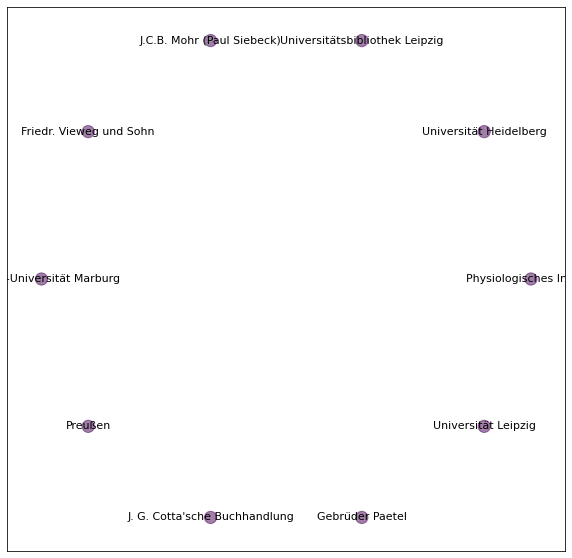

In [39]:
node_labels_names = nx.get_node_attributes(top_corps_graph, "label")

draw_graph(top_corps_graph, node_labels=node_labels)

Apparently there are no direct edges between the top ten corporations in our graph - which isn't too surprising since corporations have relationships to other node types, not amongst each other. 

Let's try a slightly different approach to visualize the subgraph. We are now creating a list of all neighboring nodes of the top ten corporations. This list we use afterwards to see if there are second level relationships between the corporations:

In [40]:
corp_neighbors = []
for i in range(len(top_corps_nodes)):
    corp_neighbors.extend([node for node in nx.all_neighbors(largest_component_graph, top_corps_nodes[i])])

corp_neighbors.extend(top_corps_nodes)
corp_neighbors_graph = largest_component_graph.subgraph(corp_neighbors)

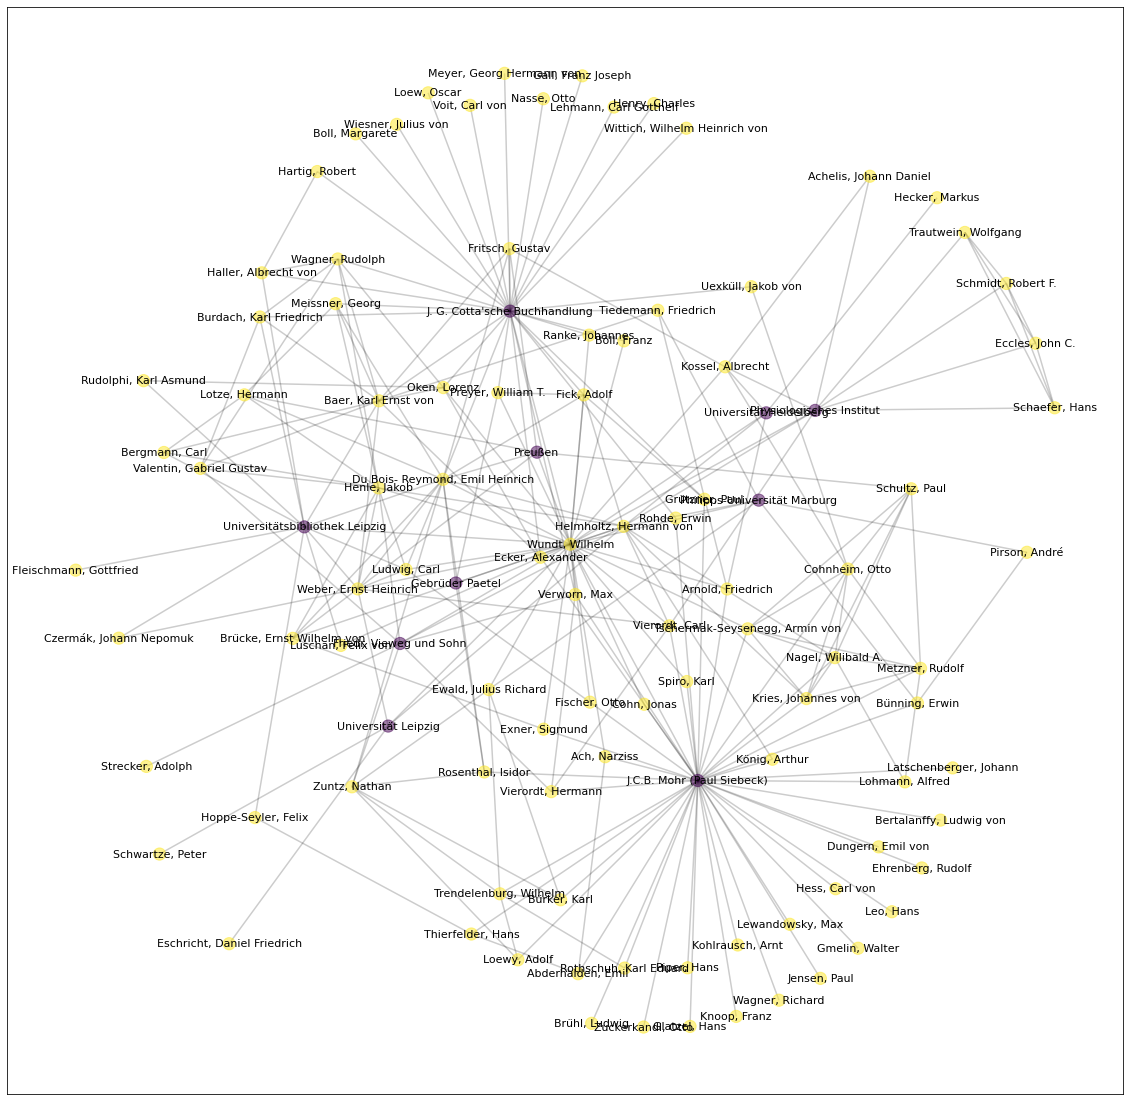

In [42]:
node_labels_names = nx.get_node_attributes(corp_neighbors_graph, "label")

draw_graph(corp_neighbors_graph, node_labels=node_labels, plot_size=[20,20])

# Investigating Resources and Works

Of course, we also can investigate the Resources and Works in the physiologist graph. Let's check out the most influential works and resources:

In [48]:
eigenvectors_sorted = sorted(eigenvectors.items(), key = itemgetter(1), reverse = True)

# apply filter to only include persons
eigenvectors_filtered = [item for item in eigenvectors_sorted if item[0] in resources_and_works_nodes]
top_eigenvectors = eigenvectors_filtered[:10]

for i in top_eigenvectors: 
    degree = eigenvectors[i[0]] 
    print("Title:", largest_component_graph.nodes(data = True)[i[0]]["Title"], "| Eigenvector Centrality:", i[1])

Title: Brief von Wilhelm Wundt an Emil Heinrich Du Bois-Reymond | Eigenvector Centrality: 0.00867689378005998
Title: Fragmente zur Physiologie. | Eigenvector Centrality: 0.008592842479991944
Title: Brief von Ludwig Lange an Max Wundt | Eigenvector Centrality: 0.008559222365873684
Title: Brief von Wilhelm Wundt an Leo Koenigsberger | Eigenvector Centrality: 0.008554911327442936
Title: Exzerpte und Entwürfe zu Medizin und Physiologie X. | Eigenvector Centrality: 0.00854885342347721
Title: Exzerpte und Entwürfe zur Philosophie VIII. | Eigenvector Centrality: 0.008508195790826152
Title: Exzerpte und Entwürfe zu verschiedenen Themen IX. | Eigenvector Centrality: 0.00850819579082614
Title: Brief von Emil Heinrich Du Bois-Reymond an Wilhelm Wundt | Eigenvector Centrality: 0.008501072207600267
Title: Brief von Wilhelm Wundt an Emil Heinrich Du Bois-Reymond | Eigenvector Centrality: 0.00850107220760026
Title: Brief von Hugo Münsterberg an Wilhelm Wundt | Eigenvector Centrality: 0.00848939122784

# Bibliography

Scifo, E. (2020). Hands-On Graph Analytics with Neo4j: Perform graph processing and visualization techniques using connected data across your enterprise. Birmingham, England: Packt Publishing.

Oldham, S., Fulcher, B., Parkes, L., Arnatkevic̆iūtė, A., Suo, C., & Fornito, A. (2019). Consistency and differences between centrality measures across distinct classes of networks. PLOS ONE, 14(7), e0220061. https://doi.org/10.1371/journal.pone.0220061